In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [114]:
# Import basic library
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from os import listdir
import time

In [53]:
DIRECTORY = "../input/yale-face-database/"

In [11]:
def list_files(directory, contains):
    return list(f for f in listdir(directory) if 
               contains in f)

## Creating Data

In [12]:
filenames = pd.DataFrame(list_files(DIRECTORY, "subject"))

df = filenames[0].str.split(".", expand=True)
df["filename"] = filenames

df = df.rename(columns = {0:"subject", 1:"category"})
df['subject'] = df.subject.str.replace('subject', '')
df.apply(pd.to_numeric, errors='coerce').dropna()
df['subject'] = pd.to_numeric(df["subject"])
df

,subject,category,filename
0,5,surprised,subject05.surprised
1,9,normal,subject09.normal
2,4,rightlight,subject04.rightlight
3,3,leftlight,subject03.leftlight
4,7,glasses,subject07.glasses
...,...,...,...
160,10,noglasses,subject10.noglasses
161,6,centerlight,subject06.centerlight
162,14,centerlight,subject14.centerlight
163,12,normal,subject12.normal


### Splitting the Dataset

In [13]:

count=np.zeros(16)
filename_train={new_list: [] for new_list in range(16)}
filename_test={new_list: [] for new_list in range(16)}
for i in range(165):
    if(count[df.iloc[i]["subject"]]<8):
        filename_train[df.iloc[i]["subject"]].append(df.iloc[i]["filename"])
        count[df.iloc[i]["subject"]]+=1
    else:
        filename_test[df.iloc[i]["subject"]].append(df.iloc[i]["filename"])
        
    

### Displaying Example Images

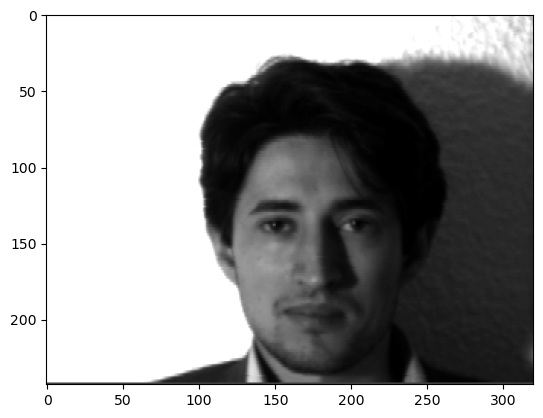

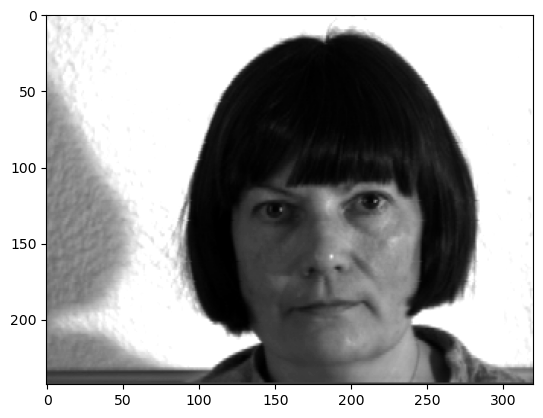

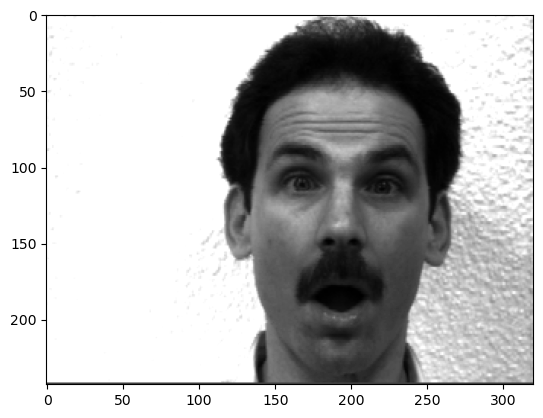

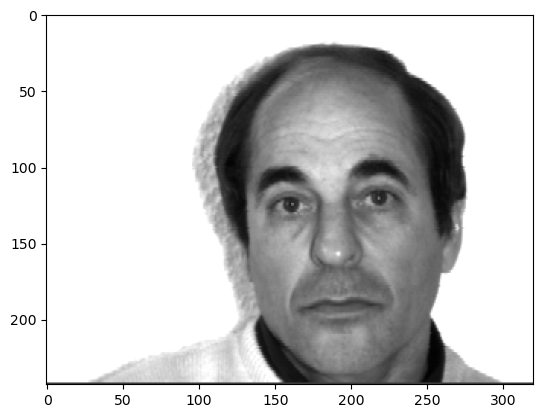

In [14]:
path1=DIRECTORY+df["filename"][3]
path2=DIRECTORY+df["filename"][6]
path3=DIRECTORY+df["filename"][7]
path4=DIRECTORY+df["filename"][9]

img1=plt.imread(path1)
img2=plt.imread(path2)
img3=plt.imread(path3)
img4=plt.imread(path4)

plt.imshow(img1,cmap='gray')
plt.show()
plt.imshow(img2,cmap='gray')
plt.show()
plt.imshow(img3,cmap='gray')
plt.show()
plt.imshow(img4,cmap='gray')
plt.show()

### Visualizing SIFT keypoints

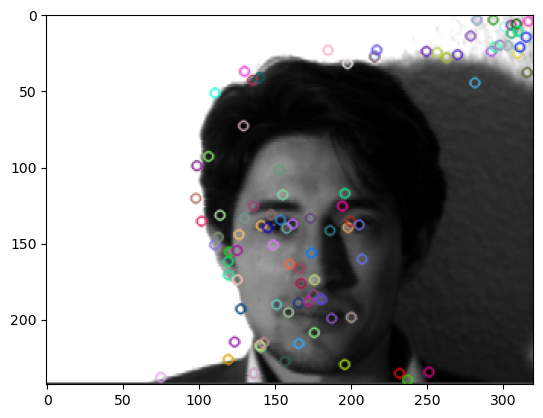

In [15]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
img = cv2.drawKeypoints(img1, kp1, img1)
plt.imshow(img,cmap='gray')

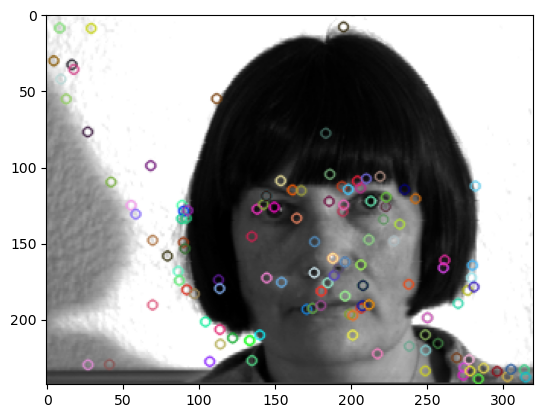

In [16]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img2,None)
img = cv2.drawKeypoints(img2, kp1, img1)
plt.imshow(img,cmap='gray')

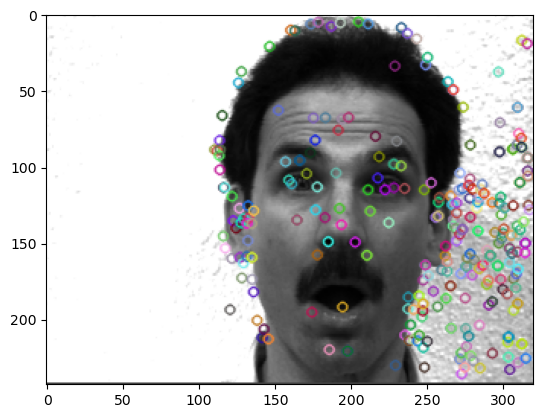

In [17]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img3,None)
img = cv2.drawKeypoints(img3, kp1, img1)
plt.imshow(img,cmap='gray')

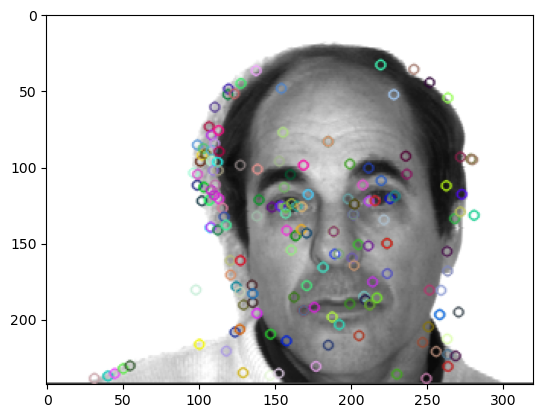

In [18]:
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img4,None)
img = cv2.drawKeypoints(img4, kp1, img1)
plt.imshow(img,cmap='gray')

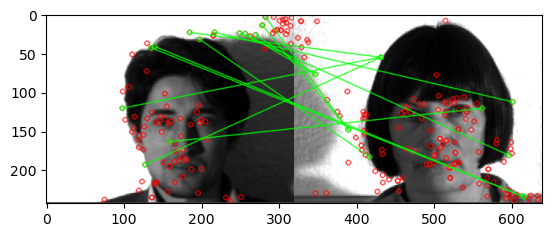

(<matplotlib.image.AxesImage at 0x7f2add04c6d0>, None)

In [92]:
# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary

# apply FLANN based matcher with knn
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
l=0
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i]=[1,0]
        l+=1
draw_params = dict(matchColor = (0,255,0),singlePointColor = (255,0,0),matchesMask = matchesMask,flags = 0)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3),plt.show()


In [20]:
X_train=[]
y_train=[]
for i in filename_train:
    for j in filename_train[i]:   
        kp,des= sift.detectAndCompute(plt.imread(DIRECTORY+j),None)
        X_train.append(des[:50].flatten())
        y_train.append(i)
    
    

In [21]:
X_test=[]
y_test=[]
for i in filename_test:
    for j in filename_test[i]:   
        kp,des= sift.detectAndCompute(plt.imread(DIRECTORY+j),None)
        X_test.append(des[:50].flatten())
        y_test.append(i)

In [22]:
X_test=np.array(X_test)
y_test=np.array(y_test)

In [26]:
y_train=y_train-1

In [27]:
y_test=y_test-1

In [25]:
X_train=np.array(X_train)
y_train=np.array(y_train)

In [28]:
y_test.shape

(45,)

In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [99]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from scipy.cluster.vq import vq

# Step 1: Feature Extraction
def extract_sift_features(image):
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Step 2: Feature Clustering
def cluster_features(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(features)
    return kmeans.cluster_centers_

# Step 3: Feature Quantization
def quantize_features(features, codebook):
    code, _ = vq(features, codebook)
    return code

# Step 4: Histogram Creation
def create_histogram(features, codebook):
    code = quantize_features(features, codebook)
    hist, _ = np.histogram(code, bins=np.arange(len(codebook)+1))
    return hist.astype(np.float32)

# Step 5: Classifier Training
def train_classifier(features, labels):
    clf = LinearSVC(max_iter=100000)
    clf.fit(features, labels)
    return clf




In [100]:
# Step 6: Feature Extraction and Histogram Creation
def extract_features_and_create_histograms(filename_train, codebook):
    features = []
    labels = []
    for i in filename_train:
        for j in filename_train[i]:
            image = plt.imread(DIRECTORY+j)
            descriptors = extract_sift_features(image)
            if descriptors is not None:
                hist = create_histogram(descriptors, codebook)
                features.append(hist)
                labels.append(i-1)
    return np.array(features), np.array(labels)

In [95]:
# Step 7: Classifier Prediction
def predict_labels(features, clf):
    return clf.predict(features)

In [163]:
# Main Function
if __name__ == '__main__':
    # Define the parameters
    num_clusters = 100
    

    # Step 1: Feature Extraction
    
    train_features = []
    for i in filename_train:
        for j in filename_train[i]:
            image = plt.imread(DIRECTORY+j)
            
            descriptors = extract_sift_features(image)
            train_features.append(descriptors)
    train_features = np.vstack(train_features)


#     # Step 5: Classifier Training
#     clf = train_classifier(train_features, train_labels)

#     # Step 7: Classifier Prediction
#     predicted_labels = predict_labels(test_features, clf)



#     # Calculate the accuracy score
#     accuracy = accuracy_score(test_labels, predicted_labels)
#     print('Accuracy:', accuracy)

In [164]:
train_features.shape

(25534, 128)

In [58]:
# Step 2: Feature Clustering
codebook = cluster_features(train_features, num_clusters)

In [166]:
# Step 3-4: Feature Quantization and Histogram Creation
train_features, train_labels = extract_features_and_create_histograms(filename_train, codebook3)
test_features, test_labels = extract_features_and_create_histograms(filename_test, codebook3)


In [167]:
a= time.time()
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

xgb_model.fit(train_features, train_labels)
y_pred = xgb_model.predict(test_features)
b=time.time()

In [168]:
b-a

0.9223477840423584

In [169]:
    # Calculate the accuracy score
    accuracy = accuracy_score(test_labels, y_pred)
    print('Accuracy:', accuracy)

Accuracy: 0.7333333333333333


In [170]:
    a=time.time()
    # Step 5: Classifier Training
    clf = train_classifier(train_features, train_labels)

    # Step 7: Classifier Prediction
    predicted_labels = predict_labels(test_features, clf)

    # Calculate the accuracy score
    accuracy = accuracy_score(test_labels, predicted_labels)
    print('Accuracy:', accuracy)
    b=time.time()

Accuracy: 0.8666666666666667


In [105]:
b-a

0.24355578422546387

In [118]:
# Step 2: Feature Clustering
codebook1 = cluster_features(train_features, 50)

In [165]:
# Step 2: Feature Clustering
codebook3 = cluster_features(train_features, 300)

In [126]:
a=time.time()
# Step 5: Classifier Training
clf = train_classifier(train_features, train_labels)

# Step 7: Classifier Prediction
predicted_labels = predict_labels(test_features, clf)

# Calculate the accuracy score
accuracy = accuracy_score(test_labels, predicted_labels)
print('Accuracy:', accuracy)
b=time.time()

Accuracy: 0.7777777777777778
